In [24]:
import pyagrum.lib.notebook as gnb
import pyagrum as gum
import pandas as pd
import numpy as np
import re

In [25]:
bn = gum.BayesNet("IncidentResponseNetwork")

RE = bn.add(gum.LabelizedVariable('Recent Deployment', 'Recent Deployment', 2))
HE = bn.add(gum.LabelizedVariable('High Error Rate', 'High Error Rate', 2))
SL = bn.add(gum.LabelizedVariable('Slowdown', 'Slowdown', 2))
LC = bn.add(gum.LabelizedVariable('High Load on our Services', 'High Load on our Services', 2))
QQ = bn.add(gum.LabelizedVariable('Dangerous Queue Status', 'Dangerous Queue Status', 2))
DB = bn.add(gum.LabelizedVariable('Dangerous Database Status', 'Dangerous Database Status', 2))
FE = bn.add(gum.LabelizedVariable('Failing External Service', 'Failing External Service', 2))
IS = bn.add(gum.LabelizedVariable('Infrastructure Scaling Failure', 'Infrastructure Scaling Failure', 2))
UU = bn.add(gum.LabelizedVariable('High User Load', 'High User Load', 2))
AL = bn.add(gum.LabelizedVariable('Alerts Triggered', 'Alerts Triggered', 2))
SE = bn.add(gum.LabelizedVariable('Severity', 'Severity', 3))
PR = bn.add(gum.LabelizedVariable('Post-Incident Response published', 'Post-Incident Response published', 2))

bn.addArc(RE, HE)
bn.addArc(RE, SL)
bn.addArc(UU, LC)
bn.addArc(IS, LC)
bn.addArc(IS, SL)
bn.addArc(LC, QQ)
bn.addArc(LC, DB)
bn.addArc(DB, SL)
bn.addArc(DB, HE)
bn.addArc(DB, AL)
bn.addArc(FE, HE)
bn.addArc(FE, SL)
bn.addArc(QQ, SL)
bn.addArc(QQ, AL)
bn.addArc(HE, AL)
bn.addArc(HE, SE)
bn.addArc(SL, AL)
bn.addArc(SL, SE)
bn.addArc(SE, PR)
bn.addArc(AL, PR)

gum.config['dynamicBN', 'default_graph_size'] = 10
gum.config["causal","default_graph_size"]=10
gum.config["notebook","default_graph_size"]=30
gum.config["notebook","default_graph_size"]=30
gum.config["notebook","default_graph_inference_size"]=30
gum.config["influenceDiagram","default_graph_size"]=30
gum.config["influenceDiagram","chance_shape"]='box'

print(bn)
bn

BN{nodes: 12, arcs: 20, domainSize: 6144, dim: 82, mem: 1Ko 256o}


(pyagrum.BayesNet@0x3889e1d0) BN{nodes: 12, arcs: 20, domainSize: 6144, dim: 82, mem: 1Ko 256o}

# Import data

## csv_file = 'interrogation_expert_platform_eng_pour_reseau_bayesien.csv'

# Function to extract probability from strings like "probable (85%)" or "50-50"
def extract_probability(value):
    value = value.strip().lower()
    if "50-50" in value:
        return 0.50
    
    match = re.search(r'\((\d{1,3})\s*%\)', value) # Used Qwen2.5 to help create this very effective regex
    if match:
        return float(match.group(1)) / 100.0
    else:
        return np.nan
        
try:
    df = pd.read_csv(csv_file, sep=';', skiprows=2, header=0)
    # Remove useless metadata first 4 columns
    df = df.iloc[:, 10:]
except Exception as e:
    print(f"Error reading CSV file: {e}")
    exit()

# Apply extraction function
df_probs = df.map(extract_probability)

# Average the probabilities across all experts (rows)
average_probs = df_probs.mean(axis=0)

for i, (question, prob) in enumerate(average_probs.items(), start=0):
    print(i, question, prob)


In [26]:
expert_data = {
    # For all Noisy OR we have a leak of 1 (cause we didn't ask expert for the leak)
    "leak": 0,
    # Root
    "P_UU": average_probs.iloc[34],
    "P_IS": average_probs.iloc[35],
    "P_FE": average_probs.iloc[37],
    "P_RE": average_probs.iloc[36],
    # High Service Load
    "P_UU_LC": average_probs.iloc[0],
    "P_IS_LC": average_probs.iloc[1],
    "P_UU_AND_IS_LC": average_probs.iloc[2],
    "P_NOT_UU_NOT_IS_LC": average_probs.iloc[3],
    # Dangerous Queue
    "P_LC_QQ": average_probs.iloc[4],
    "P_NOT_LC_QQ": average_probs.iloc[5],
    # Dangerous Database
    "P_LC_DB": average_probs.iloc[6],
    "P_NOT_LC_DB": average_probs.iloc[7],
    # NOISY High Error Rate
    "P_RE_HE": average_probs.iloc[8],
    "P_FE_HE": average_probs.iloc[9],
    "P_DB_HE": average_probs.iloc[10],
    # NOISY Slowdown
    "P_QQ_SL": average_probs.iloc[11],
    "P_DB_SL": average_probs.iloc[12],
    "P_IS_SL": average_probs.iloc[13],
    "P_RE_SL": average_probs.iloc[14],
    "P_FE_SL": average_probs.iloc[15],
    # NOISY Alerts
    "P_QQ_AL": average_probs.iloc[16],
    "P_DB_AL": average_probs.iloc[17],
    "P_SL_AL": average_probs.iloc[18],
    "P_HE_AL": average_probs.iloc[19],
    # Severity
    "P_SL_SE_P0": average_probs.iloc[20],
    "P_SL_SE_P1": average_probs.iloc[21],
    "P_SL_SE_P2": average_probs.iloc[21],
    "P_HE_SE_P0": average_probs.iloc[22],
    "P_HE_SE_P1": average_probs.iloc[23],
    "P_HE_SE_P2": average_probs.iloc[23],
    "P_NOT_SL_NOT_HE_SE_P0": average_probs.iloc[24],
    "P_NOT_SL_NOT_HE_SE_P1": average_probs.iloc[25],
    "P_NOT_SL_NOT_HE_SE_P2": average_probs.iloc[25],
    "P_SL_AND_HE_SE_P0": average_probs.iloc[26],
    "P_SL_AND_HE_SE_P1": average_probs.iloc[27],
    "P_SL_AND_HE_SE_P2": average_probs.iloc[27],
    # Post-Incident Response
    "P_SE_P0_NOT_AL_PR": average_probs.iloc[28],
    "P_SE_P1_NOT_AL_PR": average_probs.iloc[29],
    "P_SE_P2_NOT_AL_PR": average_probs.iloc[30],
    "P_SE_P0_AND_AL_PR": average_probs.iloc[31],
    "P_SE_P1_AND_AL_PR": average_probs.iloc[32],
    "P_SE_P2_AND_AL_PR": average_probs.iloc[33]
}
print(len(expert_data))

43


# Create the CPTs
(Selfhosted Qwen2.5 coder was used for generating some of these lines that were very long to do by hand.)

In [27]:
def create_root_cpt(node, idd):
    bn.cpt(node).fillWith([1-expert_data[idd],expert_data[idd]])
    print(bn.cpt(node))

create_root_cpt(UU, "P_UU")
create_root_cpt(IS, "P_IS")
create_root_cpt(FE, "P_FE")
create_root_cpt(RE, "P_RE")


  High User Load   |
0        |1        |
---------|---------|
 0.8000  | 0.2000  |


  Infrastructure Sc|
0        |1        |
---------|---------|
 0.4250  | 0.5750  |


  Failing External |
0        |1        |
---------|---------|
 0.6250  | 0.3750  |


  Recent Deployment|
0        |1        |
---------|---------|
 0.6750  | 0.3250  |



In [28]:
bn.cpt(LC).fillWith([
    1-expert_data["P_NOT_UU_NOT_IS_LC"],expert_data["P_NOT_UU_NOT_IS_LC"],
    1-expert_data["P_UU_LC"],expert_data["P_UU_LC"],
    1-expert_data["P_IS_LC"],expert_data["P_IS_LC"],
    1-expert_data["P_UU_AND_IS_LC"],expert_data["P_UU_AND_IS_LC"],
])
bn.cpt(LC)

(pyagrum.Tensor@0x36c6a7d0) 
             ||  High Load on our |
High U|Infras||0        |1        |
------|------||---------|---------|
0     |0     || 0.6750  | 0.3250  |
1     |0     || 0.6250  | 0.3750  |
0     |1     || 0.0000  | 1.0000  |
1     |1     || 0.9250  | 0.0750  |

In [29]:
bn.cpt(QQ).fillWith([
    1-expert_data["P_NOT_LC_QQ"], expert_data["P_NOT_LC_QQ"],
    1-expert_data["P_LC_QQ"],expert_data["P_LC_QQ"]
])
bn.cpt(QQ)

(pyagrum.Tensor@0x3887b360) 
      ||  Dangerous Queue S|
High L||0        |1        |
------||---------|---------|
0     || 0.5500  | 0.4500  |
1     || 0.8500  | 0.1500  |

In [30]:
bn.cpt(DB).fillWith([
    1-expert_data["P_NOT_LC_DB"], expert_data["P_NOT_LC_DB"],
    1-expert_data["P_LC_DB"],expert_data["P_LC_DB"]
])
bn.cpt(DB)

(pyagrum.Tensor@0x36f382f0) 
      ||  Dangerous Databas|
High L||0        |1        |
------||---------|---------|
0     || 0.8000  | 0.2000  |
1     || 0.8000  | 0.2000  |

In [31]:
# Noisy OR HE
bn.cpt(HE).fillWith([
    1-expert_data["leak"],expert_data["leak"],
    1-expert_data["P_RE_HE"],expert_data["P_RE_HE"],
    1-expert_data["P_DB_HE"],expert_data["P_DB_HE"],
    (1-expert_data["P_DB_HE"])*(1-expert_data["P_RE_HE"]), 1-(1-expert_data["P_DB_HE"])*(1-expert_data["P_RE_HE"]),
    1-expert_data["P_FE_HE"],expert_data["P_FE_HE"],
    (1-expert_data["P_RE_HE"])*(1-expert_data["P_FE_HE"]), 1-(1-expert_data["P_RE_HE"])*(1-expert_data["P_FE_HE"]),
    (1-expert_data["P_DB_HE"])*(1-expert_data["P_FE_HE"]), 1-(1-expert_data["P_DB_HE"])*(1-expert_data["P_FE_HE"]),
    (1-expert_data["P_DB_HE"])*(1-expert_data["P_RE_HE"])*(1-expert_data["P_FE_HE"]), 1-(1-expert_data["P_DB_HE"])*(1-expert_data["P_RE_HE"])*(1-expert_data["P_FE_HE"]),
])
bn.cpt(HE)

(pyagrum.Tensor@0x38ca1740) 
                    ||  High Error Rate  |
Recent|Danger|Failin||0        |1        |
------|------|------||---------|---------|
0     |0     |0     || 1.0000  | 0.0000  |
1     |0     |0     || 0.8000  | 0.2000  |
0     |1     |0     || 0.2000  | 0.8000  |
1     |1     |0     || 0.1600  | 0.8400  |
0     |0     |1     || 0.1500  | 0.8500  |
1     |0     |1     || 0.1200  | 0.8800  |
0     |1     |1     || 0.0300  | 0.9700  |
1     |1     |1     || 0.0240  | 0.9760  |

In [32]:
# Noisy OR for Slowdown (SL)
# Parents order specified as: RE, IS, DB, FE, QQ
bn.cpt(SL).fillWith([
    # leak (no parents)
    1-expert_data["leak"],expert_data["leak"],
    
    # Only RE active
    1-expert_data["P_RE_SL"],expert_data["P_RE_SL"],
    
    # Only IS active
    1-expert_data["P_IS_SL"],expert_data["P_IS_SL"],
    
    # IS and RE active
    (1-expert_data["P_IS_SL"])*(1-expert_data["P_RE_SL"]), 1-(1-expert_data["P_IS_SL"])*(1-expert_data["P_RE_SL"]),
    
    # Only DB active
    1-expert_data["P_DB_SL"],expert_data["P_DB_SL"],
    
    # DB and RE active
    (1-expert_data["P_DB_SL"])*(1-expert_data["P_RE_SL"]), 1-(1-expert_data["P_DB_SL"])*(1-expert_data["P_RE_SL"]),
    
    # DB and IS active
    (1-expert_data["P_DB_SL"])*(1-expert_data["P_IS_SL"]), 1-(1-expert_data["P_DB_SL"])*(1-expert_data["P_IS_SL"]),
    
    # DB, IS, and RE active
    (1-expert_data["P_DB_SL"])*(1-expert_data["P_IS_SL"])*(1-expert_data["P_RE_SL"]), 1-(1-expert_data["P_DB_SL"])*(1-expert_data["P_IS_SL"])*(1-expert_data["P_RE_SL"]),
    
    # Only FE active
    1-expert_data["P_FE_SL"],expert_data["P_FE_SL"],
    
    # FE and RE active
    (1-expert_data["P_FE_SL"])*(1-expert_data["P_RE_SL"]), 1-(1-expert_data["P_FE_SL"])*(1-expert_data["P_RE_SL"]),
    
    # FE and IS active
    (1-expert_data["P_FE_SL"])*(1-expert_data["P_IS_SL"]), 1-(1-expert_data["P_FE_SL"])*(1-expert_data["P_IS_SL"]),
    
    # FE, IS, and RE active
    (1-expert_data["P_FE_SL"])*(1-expert_data["P_IS_SL"])*(1-expert_data["P_RE_SL"]), 1-(1-expert_data["P_FE_SL"])*(1-expert_data["P_IS_SL"])*(1-expert_data["P_RE_SL"]),
    
    # FE and DB active
    (1-expert_data["P_FE_SL"])*(1-expert_data["P_DB_SL"]), 1-(1-expert_data["P_FE_SL"])*(1-expert_data["P_DB_SL"]),
    
    # FE, DB, and RE active
    (1-expert_data["P_FE_SL"])*(1-expert_data["P_DB_SL"])*(1-expert_data["P_RE_SL"]), 1-(1-expert_data["P_FE_SL"])*(1-expert_data["P_DB_SL"])*(1-expert_data["P_RE_SL"]),
    
    # FE, DB, and IS active
    (1-expert_data["P_FE_SL"])*(1-expert_data["P_DB_SL"])*(1-expert_data["P_IS_SL"]), 1-(1-expert_data["P_FE_SL"])*(1-expert_data["P_DB_SL"])*(1-expert_data["P_IS_SL"]),
    
    # FE, DB, IS, and RE active
    (1-expert_data["P_FE_SL"])*(1-expert_data["P_DB_SL"])*(1-expert_data["P_IS_SL"])*(1-expert_data["P_RE_SL"]), 1-(1-expert_data["P_FE_SL"])*(1-expert_data["P_DB_SL"])*(1-expert_data["P_IS_SL"])*(1-expert_data["P_RE_SL"]),
    
    # Only QQ active
    1-expert_data["P_QQ_SL"],expert_data["P_QQ_SL"],
    
    # QQ and RE active
    (1-expert_data["P_QQ_SL"])*(1-expert_data["P_RE_SL"]), 1-(1-expert_data["P_QQ_SL"])*(1-expert_data["P_RE_SL"]),
    
    # QQ and IS active
    (1-expert_data["P_QQ_SL"])*(1-expert_data["P_IS_SL"]), 1-(1-expert_data["P_QQ_SL"])*(1-expert_data["P_IS_SL"]),
    
    # QQ, IS, and RE active
    (1-expert_data["P_QQ_SL"])*(1-expert_data["P_IS_SL"])*(1-expert_data["P_RE_SL"]), 1-(1-expert_data["P_QQ_SL"])*(1-expert_data["P_IS_SL"])*(1-expert_data["P_RE_SL"]),
    
    # QQ and DB active
    (1-expert_data["P_QQ_SL"])*(1-expert_data["P_DB_SL"]), 1-(1-expert_data["P_QQ_SL"])*(1-expert_data["P_DB_SL"]),
    
    # QQ, DB, and RE active
    (1-expert_data["P_QQ_SL"])*(1-expert_data["P_DB_SL"])*(1-expert_data["P_RE_SL"]), 1-(1-expert_data["P_QQ_SL"])*(1-expert_data["P_DB_SL"])*(1-expert_data["P_RE_SL"]),
    
    # QQ, DB, and IS active
    (1-expert_data["P_QQ_SL"])*(1-expert_data["P_DB_SL"])*(1-expert_data["P_IS_SL"]), 1-(1-expert_data["P_QQ_SL"])*(1-expert_data["P_DB_SL"])*(1-expert_data["P_IS_SL"]),
    
    # QQ, DB, IS, and RE active
    (1-expert_data["P_QQ_SL"])*(1-expert_data["P_DB_SL"])*(1-expert_data["P_IS_SL"])*(1-expert_data["P_RE_SL"]), 1-(1-expert_data["P_QQ_SL"])*(1-expert_data["P_DB_SL"])*(1-expert_data["P_IS_SL"])*(1-expert_data["P_RE_SL"]),
    
    # QQ and FE active
    (1-expert_data["P_QQ_SL"])*(1-expert_data["P_FE_SL"]), 1-(1-expert_data["P_QQ_SL"])*(1-expert_data["P_FE_SL"]),
    
    # QQ, FE, and RE active
    (1-expert_data["P_QQ_SL"])*(1-expert_data["P_FE_SL"])*(1-expert_data["P_RE_SL"]), 1-(1-expert_data["P_QQ_SL"])*(1-expert_data["P_FE_SL"])*(1-expert_data["P_RE_SL"]),
    
    # QQ, FE, and IS active
    (1-expert_data["P_QQ_SL"])*(1-expert_data["P_FE_SL"])*(1-expert_data["P_IS_SL"]), 1-(1-expert_data["P_QQ_SL"])*(1-expert_data["P_FE_SL"])*(1-expert_data["P_IS_SL"]),
    
    # QQ, FE, IS, and RE active
    (1-expert_data["P_QQ_SL"])*(1-expert_data["P_FE_SL"])*(1-expert_data["P_IS_SL"])*(1-expert_data["P_RE_SL"]), 1-(1-expert_data["P_QQ_SL"])*(1-expert_data["P_FE_SL"])*(1-expert_data["P_IS_SL"])*(1-expert_data["P_RE_SL"]),
    
    # QQ, FE, and DB active
    (1-expert_data["P_QQ_SL"])*(1-expert_data["P_FE_SL"])*(1-expert_data["P_DB_SL"]), 1-(1-expert_data["P_QQ_SL"])*(1-expert_data["P_FE_SL"])*(1-expert_data["P_DB_SL"]),
    
    # QQ, FE, DB, and RE active
    (1-expert_data["P_QQ_SL"])*(1-expert_data["P_FE_SL"])*(1-expert_data["P_DB_SL"])*(1-expert_data["P_RE_SL"]), 1-(1-expert_data["P_QQ_SL"])*(1-expert_data["P_FE_SL"])*(1-expert_data["P_DB_SL"])*(1-expert_data["P_RE_SL"]),
    
    # QQ, FE, DB, and IS active
    (1-expert_data["P_QQ_SL"])*(1-expert_data["P_FE_SL"])*(1-expert_data["P_DB_SL"])*(1-expert_data["P_IS_SL"]), 1-(1-expert_data["P_QQ_SL"])*(1-expert_data["P_FE_SL"])*(1-expert_data["P_DB_SL"])*(1-expert_data["P_IS_SL"]),
    
    # All five parents active (QQ, FE, DB, IS, RE)
    (1-expert_data["P_QQ_SL"])*(1-expert_data["P_FE_SL"])*(1-expert_data["P_DB_SL"])*(1-expert_data["P_IS_SL"])*(1-expert_data["P_RE_SL"]), 1-(1-expert_data["P_QQ_SL"])*(1-expert_data["P_FE_SL"])*(1-expert_data["P_DB_SL"])*(1-expert_data["P_IS_SL"])*(1-expert_data["P_RE_SL"]),
])
bn.cpt(SL)


(pyagrum.Tensor@0x38cac8c0) 
                                  ||  Slowdown         |
Recent|Infras|Danger|Failin|Danger||0        |1        |
------|------|------|------|------||---------|---------|
0     |0     |0     |0     |0     || 1.0000  | 0.0000  |
1     |0     |0     |0     |0     || 0.6250  | 0.3750  |
0     |1     |0     |0     |0     || 0.8500  | 0.1500  |
1     |1     |0     |0     |0     || 0.5312  | 0.4688  |
0     |0     |1     |0     |0     || 0.6250  | 0.3750  |
1     |0     |1     |0     |0     || 0.3906  | 0.6094  |
[...20 more line(s) ...]
0     |1     |0     |1     |1     || 0.0239  | 0.9761  |
1     |1     |0     |1     |1     || 0.0149  | 0.9851  |
0     |0     |1     |1     |1     || 0.0176  | 0.9824  |
1     |0     |1     |1     |1     || 0.0110  | 0.9890  |
0     |1     |1     |1     |1     || 0.0149  | 0.9851  |
1     |1     |1     |1     |1     || 0.0093  | 0.9907  |

In [33]:
# Noisy OR for Alerts
bn.cpt(AL).fillWith([
    # No parent active - just leak
    1-expert_data["leak"],expert_data["leak"],
    
    # Only DB active
    1-expert_data["P_DB_AL"],expert_data["P_DB_AL"],
    
    # Only QQ active
    1-expert_data["P_QQ_AL"],expert_data["P_QQ_AL"],
    
    # DB and QQ active
    (1-expert_data["P_DB_AL"])*(1-expert_data["P_QQ_AL"]), 1-(1-expert_data["P_DB_AL"])*(1-expert_data["P_QQ_AL"]),
    
    # Only HE active
    1-expert_data["P_HE_AL"],expert_data["P_HE_AL"],

    # HE and DB active
    (1-expert_data["P_HE_AL"])*(1-expert_data["P_DB_AL"]), 1-(1-expert_data["P_HE_AL"])*(1-expert_data["P_DB_AL"]),
    
    # HE and QQ active
    (1-expert_data["P_HE_AL"])*(1-expert_data["P_QQ_AL"]), 1-(1-expert_data["P_HE_AL"])*(1-expert_data["P_QQ_AL"]),
    
    # HE, DB, and QQ active
    (1-expert_data["P_HE_AL"])*(1-expert_data["P_DB_AL"])*(1-expert_data["P_QQ_AL"]), 1-(1-expert_data["P_HE_AL"])*(1-expert_data["P_DB_AL"])*(1-expert_data["P_QQ_AL"]),
 
    # Only SL active
    1-expert_data["P_SL_AL"],expert_data["P_SL_AL"],

    # SL and DB active
    (1-expert_data["P_SL_AL"])*(1-expert_data["P_DB_AL"]), 1-(1-expert_data["P_SL_AL"])*(1-expert_data["P_DB_AL"]),
    
    # SL and QQ active
    (1-expert_data["P_SL_AL"])*(1-expert_data["P_QQ_AL"]), 1-(1-expert_data["P_SL_AL"])*(1-expert_data["P_QQ_AL"]),

    # SL, DB, and QQ active
    (1-expert_data["P_SL_AL"])*(1-expert_data["P_DB_AL"])*(1-expert_data["P_QQ_AL"]), 1-(1-expert_data["P_SL_AL"])*(1-expert_data["P_DB_AL"])*(1-expert_data["P_QQ_AL"]),
    
    # HE and SL active
    (1-expert_data["P_HE_AL"])*(1-expert_data["P_SL_AL"]), 1-(1-expert_data["P_HE_AL"])*(1-expert_data["P_SL_AL"]),
    
    # HE, SL, and DB active
    (1-expert_data["P_HE_AL"])*(1-expert_data["P_SL_AL"])*(1-expert_data["P_DB_AL"]), 1-(1-expert_data["P_HE_AL"])*(1-expert_data["P_SL_AL"])*(1-expert_data["P_DB_AL"]),
    
    # HE, SL, and QQ active
    (1-expert_data["P_HE_AL"])*(1-expert_data["P_SL_AL"])*(1-expert_data["P_QQ_AL"]), 1-(1-expert_data["P_HE_AL"])*(1-expert_data["P_SL_AL"])*(1-expert_data["P_QQ_AL"]),
       
    # All four parents active (HE, SL, DB, QQ)
    (1-expert_data["P_HE_AL"])*(1-expert_data["P_SL_AL"])*(1-expert_data["P_DB_AL"])*(1-expert_data["P_QQ_AL"]), 1-(1-expert_data["P_HE_AL"])*(1-expert_data["P_SL_AL"])*(1-expert_data["P_DB_AL"])*(1-expert_data["P_QQ_AL"]),
])
bn.cpt(AL)

(pyagrum.Tensor@0x385699e0) 
                           ||  Alerts Triggered |
Danger|Danger|High E|Slowdo||0        |1        |
------|------|------|------||---------|---------|
0     |0     |0     |0     || 1.0000  | 0.0000  |
1     |0     |0     |0     || 0.3250  | 0.6750  |
0     |1     |0     |0     || 0.2000  | 0.8000  |
1     |1     |0     |0     || 0.0650  | 0.9350  |
0     |0     |1     |0     || 0.8000  | 0.2000  |
1     |0     |1     |0     || 0.2600  | 0.7400  |
[...4 more line(s) ...]
0     |1     |0     |1     || 0.0500  | 0.9500  |
1     |1     |0     |1     || 0.0162  | 0.9838  |
0     |0     |1     |1     || 0.2000  | 0.8000  |
1     |0     |1     |1     || 0.0650  | 0.9350  |
0     |1     |1     |1     || 0.0400  | 0.9600  |
1     |1     |1     |1     || 0.0130  | 0.9870  |

In [34]:
bn.cpt(SE).fillWith([
    expert_data["P_NOT_SL_NOT_HE_SE_P0"],expert_data["P_NOT_SL_NOT_HE_SE_P1"], expert_data["P_NOT_SL_NOT_HE_SE_P2"],
    expert_data["P_HE_SE_P0"], expert_data["P_HE_SE_P1"], expert_data["P_HE_SE_P2"],
    expert_data["P_SL_SE_P0"], expert_data["P_SL_SE_P1"], expert_data["P_SL_SE_P2"],
    expert_data["P_SL_AND_HE_SE_P0"], expert_data["P_SL_AND_HE_SE_P1"], expert_data["P_SL_AND_HE_SE_P2"],
])
bn.cpt(SE)

(pyagrum.Tensor@0x387d2ee0) 
             ||  Severity                   |
High E|Slowdo||0        |1        |2        |
------|------||---------|---------|---------|
0     |0     || 0.0000  | 0.6750  | 0.6750  |
1     |0     || 0.6250  | 0.0000  | 0.0000  |
0     |1     || 0.2000  | 0.5750  | 0.5750  |
1     |1     || 0.6250  | 0.5000  | 0.5000  |

In [35]:
bn.cpt(PR).fillWith([
    1-expert_data["P_SE_P0_NOT_AL_PR"],expert_data["P_SE_P0_NOT_AL_PR"],
    1-expert_data["P_SE_P1_NOT_AL_PR"],expert_data["P_SE_P1_NOT_AL_PR"],
    1-expert_data["P_SE_P2_NOT_AL_PR"],expert_data["P_SE_P2_NOT_AL_PR"],
    1-expert_data["P_SE_P0_AND_AL_PR"],expert_data["P_SE_P0_AND_AL_PR"],
    1-expert_data["P_SE_P1_AND_AL_PR"],expert_data["P_SE_P1_AND_AL_PR"],
    1-expert_data["P_SE_P2_AND_AL_PR"],expert_data["P_SE_P2_AND_AL_PR"],
])

(pyagrum.Tensor@0x388a7af0) 
             ||  Post-Incident Res|
Severi|Alerts||0        |1        |
------|------||---------|---------|
0     |0     || 0.4500  | 0.5500  |
1     |0     || 0.5750  | 0.4250  |
2     |0     || 0.0000  | 1.0000  |
0     |1     || 0.0000  | 1.0000  |
1     |1     || 0.5750  | 0.4250  |
2     |1     || 0.5000  | 0.5000  |

# Inference

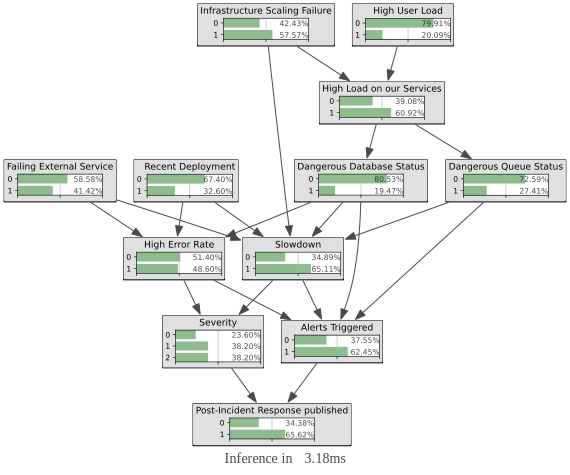

In [36]:
# We create the inference object 
ie=gum.LazyPropagation(bn)
# We use the inference object to calculate our scenarios:
gnb.showInference(bn,evs={})

Interestingly, the probability of no alerts being triggered is very close to the probability of no post-incident review being published. This makes sense – the team is unlikely to write a post-incident review if they weren't alerted that an incident is happening. 

However, this also highlights a gap in my current network. In reality, incidents can sometimes also be identified through channels other than automated alerts, such as support tickets raised by clients or team members noticing unusual product behavior in production.

## Scenario 1 :
A recent deployment has pushed new code in production, but we don't observe an increase in the global error rate in production, What's the severity of this incident ?

In [37]:
ie.setEvidence({'Recent Deployment':1, 'High Error Rate': 0})
ie.makeInference()
print("Severity probabilities:")
ie.posterior("Severity")

Severity probabilities:


(pyagrum.Tensor@0x389ace70) 
  Severity                   |
0        |1        |2        |
---------|---------|---------|
 0.0845  | 0.4578  | 0.4578  |

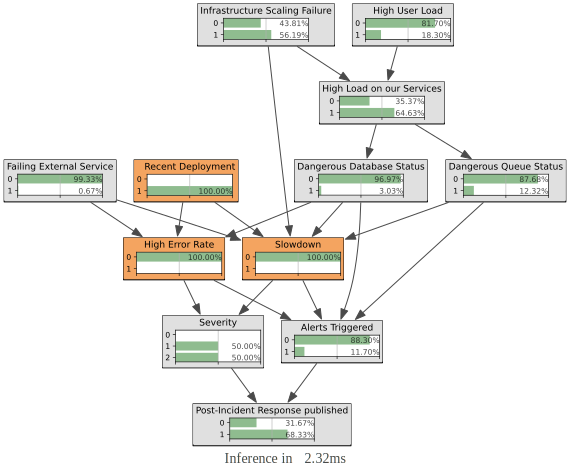

In [44]:
gnb.showInference(bn,evs={'Recent Deployment':1,'High Error Rate':0, 'Slowdown':0})

This one also makes sense, a recent code deployment that don't raise the error rate and the efficiency of the platform is very very unlikely to be the causes of an incident with high Severity like P0.

## Scenario 2 :
Alerts are firing and we observe slowdown in production, What's the causes ?

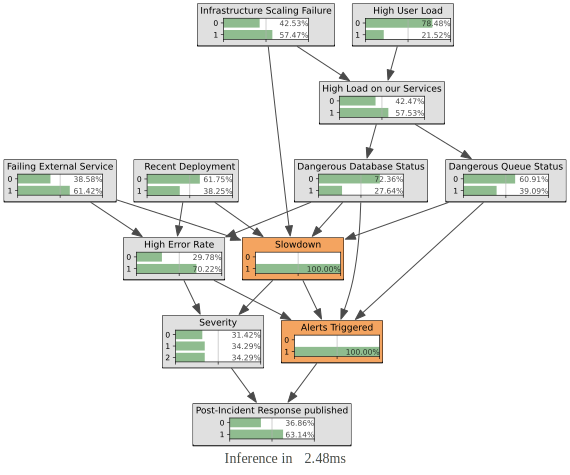

In [39]:
gnb.showInference(bn,evs={'Alerts Triggered':1,'Slowdown':1})

This one is an interesting scenario, it looks like that only by observing Slowdown and Alerts we cannot easily find one root causes of the problem, as all the causes still have very similar probabilities.

## Scenario 3: 
Alerts are Firing, but we know it wasn't a Deployment

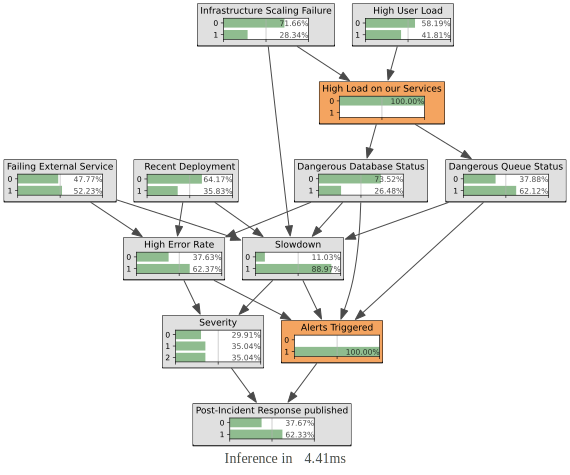

In [47]:
gnb.showInference(bn, evs={'Alerts Triggered': 1, 'High Load on our Services': 0})

## Scenario 4:
High User Load AND Infrastructure Scaling Failure

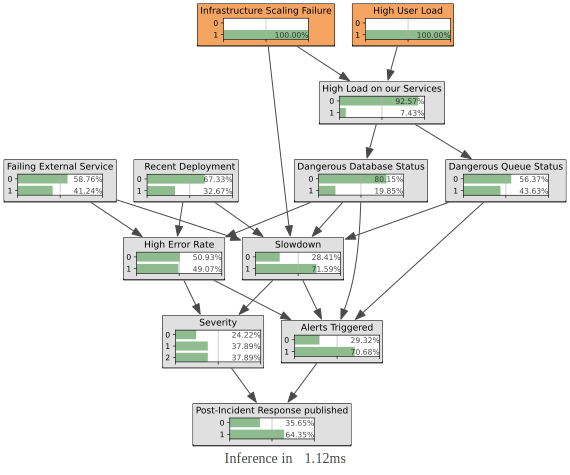

In [41]:
gnb.showInference(bn, evs={'High User Load': 1, 'Infrastructure Scaling Failure': 1})

## Scenario 5:
High User Load and Recent Deployment happened, but no High Load on Services yet observed

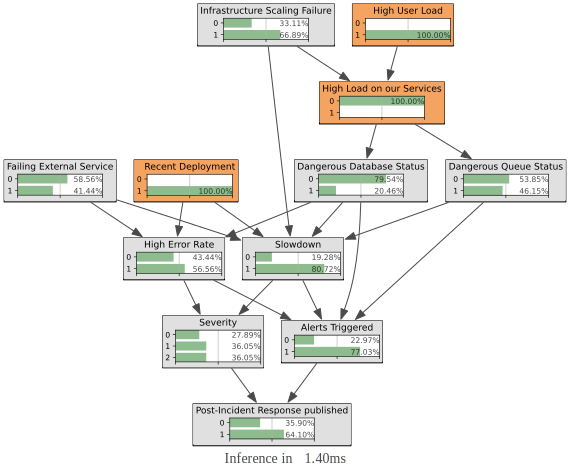

In [42]:
gnb.showInference(bn, evs={'High User Load': 1, 'Recent Deployment': 1, 'High Load on our Services': 0})

## Scenario 6:

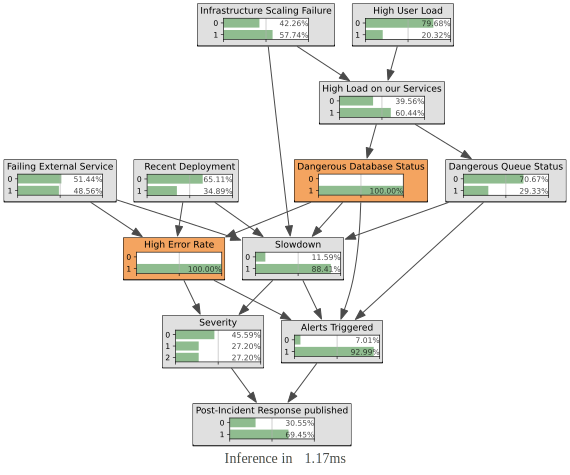

In [43]:
gnb.showInference(bn, evs={'Dangerous Database Status': 1, 'High Error Rate':1})